# Hypothesis 1

There is a relation between EEG signal and 3 levels of stress.

For each pair of person and task, there are 3 distinct groups of EEG signals representing the 3 levels of stress.

In [1]:
from utils import *
import pandas as pd
import mne
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import normalize

In [2]:
# start : begin of question
# T: answer correct
# F: answer incorrect
# S: not answer in time
# O: unexpected key press
marker_names = [0,
            'math,LowStress,start',
            'math,LowStress,T',
            'math,LowStress,F',
            'math,LowStress,S',
            'math,LowStress,O',
            'math,MildStress,start',
            'math,MildStress,T',
            'math,MildStress,F',
            'math,MildStress,S',
            'math,MildStress,O',
            'math,HigherStress,start',
            'math,HigherStress,T',
            'math,HigherStress,F',
            'math,HigherStress,S',
            'math,HigherStress,O',
            'fixation,None,None']

In [3]:
# task = "mathcontrol" 
task = "mathstress"

files = glob(f"data/*_{task}_*.csv")
names = []
pd_raws = []
raws = []
with tqdm(files) as pbar:
    for index, f in enumerate(pbar):
        name, task, t_stamp = f.split('/')[1].split('_')
        names.append(name)
        pbar.set_description(f"{index} {name}")
        pd_raw = pd.read_csv(f, dtype={'Marker':str})
        pd_raw = marker_converter(pd_raw,marker_names)
        pd_raws.append(pd_raw)

print(f"index\tname\tfile_name")
print("="*30)
for index in range(len(names)):
    print(f"{index}\t{names[index]}\t{files[index]}")

  0%|          | 0/7 [00:00<?, ?it/s]

index	name	file_name
0	prin	data/prin_mathstress_2021-08-13-06.37.39.csv
1	pumpath	data/pumpath_mathstress_2021-08-12-03.22.27.csv
2	krittithee	data/krittithee_mathstress_2021-08-13-04.47.53.csv
3	nuttasit	data/nuttasit_mathstress_2021-08-12-08.09.53.csv
4	nutcha	data/nutcha_mathstress_2021-08-10-12.18.33.csv
5	surangrat	data/surangrat_mathstress_2021-08-12-05.08.24.csv
6	dusadee	data/dusadee_mathstress_2021-08-12-06.43.45.csv


In [4]:
raws = []
sampling_rate = 250 # Hz
with tqdm(pd_raws) as pbar:
    for index,pd_raw in enumerate(pbar):
        pbar.set_description(f"{index} {names[index]}")
        raw = dataframe_to_raw(pd_raw, sfreq=sampling_rate)
        raws.append(raw)

  0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# Preprocess
for raw in raws:
    raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
    raw.filter(1, None, verbose=False) # Slow drift
    # ica = mne.preprocessing.ICA(n_components=8, max_iter='auto')
    # ica.fit(raw, verbose=False)
    # raw = ica.apply(raw, verbose=False)
    pass

In [6]:
# for m in pd_raws[0]['Marker'].unique():
#     print(marker_names[m])

0
math,LowStress,start
math,LowStress,T
math,LowStress,F
math,LowStress,S
fixation,None,None
math,MildStress,start
math,MildStress,T
math,MildStress,S
math,MildStress,F
math,HigherStress,start
math,HigherStress,F
math,HigherStress,T
math,HigherStress,O
math,HigherStress,S


In [15]:
interested_marker_names = ['math,LowStress,start','math,MildStress,start','math,HigherStress,start','fixation,None,None']
interested_markers = [ marker_names.index(name) for name in interested_marker_names ]
events_list = []
with tqdm(raws) as pbar:
    for index,raw in enumerate(pbar):
        pbar.set_description(f"{index} {names[index]}")
        print(f"Participant:'{names[index]}'")
        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False, uint_cast=False)
        # marker_names[0] is 0, so skip
        for marker_name in marker_names[1:]:
            task, level, m = marker_name.split(',')
            # if(marker_name not in marker_names): continue
            number = sum(events[::,2] == marker_names.index(marker_name))
            if(m == 'start'): print(f"\tNumber of '{level}' questions: {number}")
            if(m == 'T'): print(f"\t\tCorrect: {number}")
            if(m == 'F'): print(f"\t\tWrong: {number}")
            if(m == 'S'): print(f"\t\tSlow: {number}")
            if(m == 'O'): print(f"\t\tOut of range: {number}")
        print("="*30)

        uninterested_markers = list(set(np.unique(events[::,2])).difference(set(interested_markers)))
        for marker in uninterested_markers:
            events = np.delete(events, np.argwhere(events[:,2] == marker), axis=0) 
        events_list.append(events)
        # break




  0%|          | 0/7 [00:00<?, ?it/s]

Participant:'prin'
	Number of 'LowStress' questions: 68
		Correct: 53
		Wrong: 9
		Slow: 6
		Out of range: 0
	Number of 'MildStress' questions: 46
		Correct: 19
		Wrong: 13
		Slow: 14
		Out of range: 0
	Number of 'HigherStress' questions: 28
		Correct: 8
		Wrong: 8
		Slow: 6
		Out of range: 6
Participant:'pumpath'
	Number of 'LowStress' questions: 59
		Correct: 45
		Wrong: 3
		Slow: 11
		Out of range: 0
	Number of 'MildStress' questions: 27
		Correct: 12
		Wrong: 13
		Slow: 2
		Out of range: 0
	Number of 'HigherStress' questions: 20
		Correct: 11
		Wrong: 9
		Slow: 0
		Out of range: 0
Participant:'krittithee'
	Number of 'LowStress' questions: 53
		Correct: 32
		Wrong: 10
		Slow: 11
		Out of range: 0
	Number of 'MildStress' questions: 33
		Correct: 18
		Wrong: 11
		Slow: 4
		Out of range: 0
	Number of 'HigherStress' questions: 15
		Correct: 7
		Wrong: 3
		Slow: 5
		Out of range: 0
Participant:'nuttasit'
	Number of 'LowStress' questions: 79
		Correct: 49
		Wrong: 4
		Slow: 26
		Out of ra

In [19]:
# Here we only get the event that indicate the begining of the block and fixation.
interested_events_list = []
with tqdm(events_list) as pbar:
    for index, events in enumerate(pbar):
        pbar.set_description(f"{index} {names[index]}")
        interested_events = []
        prev_is_Low_start = False
        prev_is_Mil_start = False
        prev_is_Hig_start = False
        Low_start = marker_names.index('math,LowStress,start')
        Mil_start = marker_names.index('math,MildStress,start')
        Hig_start = marker_names.index('math,HigherStress,start')

        for event in events:
            if(event[2] == Low_start and prev_is_Low_start == False):
                interested_events.append(list(event))
                prev_is_Low_start = True
            elif(event[2] != Low_start):
                prev_is_Low_start = False

            if(event[2] == Mil_start and prev_is_Mil_start == False):
                interested_events.append(list(event))
                prev_is_Mil_start = True
            elif(event[2] != Mil_start):
                prev_is_Mil_start = False

            if(event[2] == Hig_start and prev_is_Hig_start == False):
                interested_events.append(list(event))
                prev_is_Hig_start = True
            elif(event[2] != Hig_start):
                prev_is_Hig_start = False


            if(event[2] == marker_names.index('fixation,None,None')):
                interested_events.append(list(event))
            # print(event)
        interested_events = np.array(interested_events)
        interested_events_list.append(interested_events)

  0%|          | 0/7 [00:00<?, ?it/s]

In [25]:
# Here we split the block into chuncks
chunck_size = 5 # second
chunck_events_list = []
num_chunck = None
with tqdm(interested_events_list) as pbar:
    for index, interested_events in enumerate(pbar):
        m_start = interested_events[0::2]
        m_stop = interested_events[1::2]
        chunck_events = []
        for index, (start, stop) in enumerate(zip(m_start, m_stop)):
            # [time_stamp, _, marker]
            a = start[2] in interested_markers
            b = stop[2] == marker_names.index('fixation,None,None')
            if((a and b) == False):
                raise ValueError(f"at {index}, found unexpected marker order. start='{marker_names[start[2]]}' stop='{marker_names[stop[2]]}'")
            for i in range(start[0], start[0]+(30*250)+1, chunck_size*250):
                if(i + chunck_size*250 >= stop[0]):
                    raise ValueError(f"start stop is incorrect.")
                chunck_events.append([i,0,start[2]])

        chunck_events = np.array(chunck_events)
        chunck_events_list.append(chunck_events)
        num_low = sum(chunck_events[::,2] == marker_names.index('math,LowStress,start'))
        num_mil = sum(chunck_events[::,2] == marker_names.index('math,MildStress,start'))
        num_hig = sum(chunck_events[::,2] == marker_names.index('math,HigherStress,start'))
        if(num_low != num_mil or num_mil != num_hig):
            raise ValueError(f"The number of chuncked events is not equal. LowStress={num_low} MildStress={num_mil} HigherStress={num_hig}")
        print(f"Number of samples of each block: {num_low}")
        num_chunck = num_low


  0%|          | 0/7 [00:00<?, ?it/s]

Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28
Number of samples of each block: 28


In [26]:
# 0,4 Delta
# 4,8 Theta
# 8,16 Alpha ***
# 16,32 Beta 
# 32,64 Noisy Gamma
# 64,128 Noisy Signal
# frequencies = np.arange(8, 32+1, 8)

frequencies = np.array([10,11,12,13,14])
t_start, t_stop = 0.3, 4.8
features_list = []
labels_list = []
with tqdm(raws) as pbar:
    for index_1, raw in enumerate(pbar):
        pbar.set_description(f"{index_1} {names[index_1]}")
        raw, chunck_events = raws[index_1], chunck_events_list[index_1]
        features = []
        labels = []
        epochs = mne.Epochs(raw, chunck_events, tmin=t_start, tmax=t_stop, baseline=(t_start,t_stop), verbose=False)

        for index, evoked in enumerate(epochs.iter_evoked()):
            event = evoked.comment
            tfr_obj = mne.time_frequency.tfr_morlet(evoked, n_cycles=3, return_itc=False, freqs=frequencies, decim=3)
            # (channel,freq,time-window)
            coeff = tfr_obj.data 
            # (freq,time-window)
            coeff = coeff.mean(axis=0)
            # alpha mean
            coeff = coeff.mean()
            features.append(coeff)
            labels.append(event)
        features_list.append(features)
        labels_list.append(labels)
# features = np.array(features)
# features.shape

  0%|          | 0/7 [00:00<?, ?it/s]

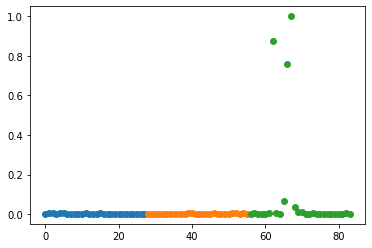

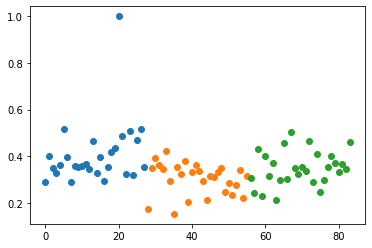

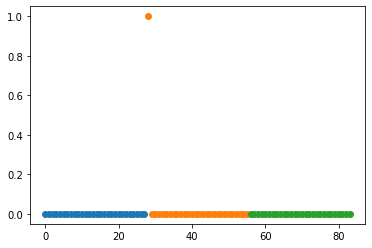

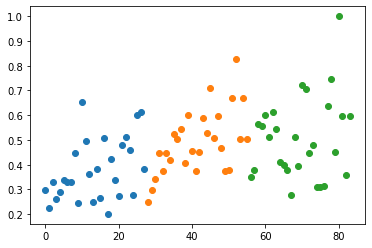

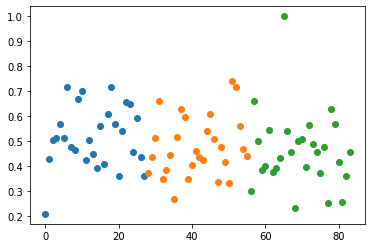

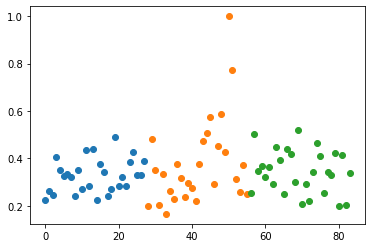

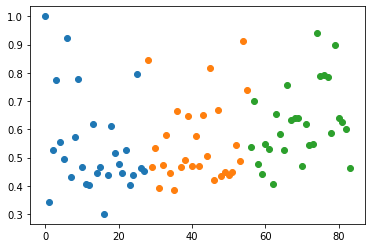

In [28]:
for features in features_list:
    f_norm = normalize(np.array(features).reshape(-1,1), axis=0, norm='max')
    # f_norm = np.array(features).reshape(-1,1)
    plt.scatter(range(num_chunck*0,num_chunck*1),f_norm[num_chunck*0:num_chunck*1])
    plt.scatter(range(num_chunck*1,num_chunck*2),f_norm[num_chunck*1:num_chunck*2])
    plt.scatter(range(num_chunck*2,num_chunck*3),f_norm[num_chunck*2:num_chunck*3])
    plt.show()